In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter

plt.style.use('seaborn')
%matplotlib inline

In [2]:
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

green_list_df = pd.read_csv('data/Green_misc_insertions_210527.csv')
date = '5/27/21'


In [4]:
today_df = green_list_df.loc[green_list_df['date'] == date]


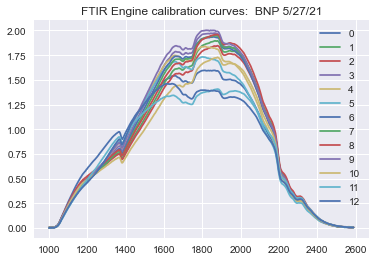

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210527_BNP/BNP_210527.h5'
file = path_name + file_name
calibrations = ['session001/cal001', 'session001/cal002', 'session001/cal003', 'session001/cal004', 'session001/cal005',
               'session001/cal006', 'session001/cal007', 'session001/cal008', 'session001/cal009', 'session001/cal010',
                'session001/cal011', 'session001/cal012', 'session001/cal013']
cal_curves = []
waves = get_ftir_wavelength_vector(file, calibrations[0])
for calibration_path in calibrations:
    cal_curve = get_ftir_white_calibration_curve(file, calibration_path)
    cal_curves.append(cal_curve)

fig, ax = plt.subplots()
ax.set_title("FTIR Engine calibration curves:  BNP 5/27/21")
for i in range(len(cal_curves)):
    ax.plot(waves, cal_curves[i], label=i)
ax.legend()
plt.show()
plt.close()



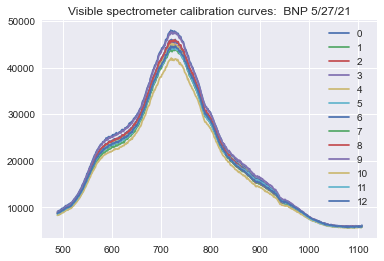

In [6]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = '210527_BNP/BNP_210527.h5'
file = path_name + file_name
calibrations = ['session001/cal001', 'session001/cal002', 'session001/cal003', 'session001/cal004', 'session001/cal005',
               'session001/cal006', 'session001/cal007', 'session001/cal008', 'session001/cal009', 'session001/cal010',
                'session001/cal011', 'session001/cal012', 'session001/cal013']
cal_curves = []
waves = get_visible_wavelength_vector(file, calibrations[0])
for calibration_path in calibrations:
    cal_curve = get_visible_white_calibration_curve(file, calibration_path)
    cal_curves.append(cal_curve)

fig, ax = plt.subplots()
ax.set_title("Visible spectrometer calibration curves:  BNP 5/27/21")
for i in range(len(cal_curves)):
    ax.plot(waves, cal_curves[i], label=i)
ax.legend()
plt.show()
plt.close()

/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/210524_green_tests/blah_two_spects_210523.h5 session005/cal001


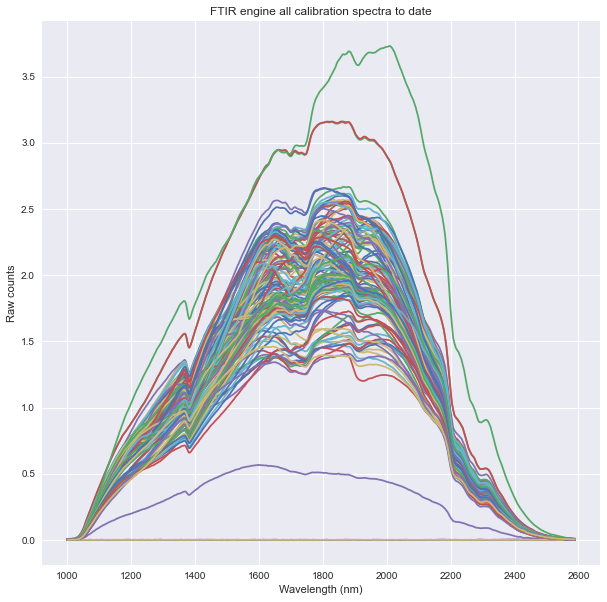

In [7]:
df = pd.read_csv('data/All_green_files210527.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR engine all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum)
    except:
        print(file, cal_path)
plt.show()
plt.close()


210524_green_tests/blah_two_spects_210523.h5 session005/cal001


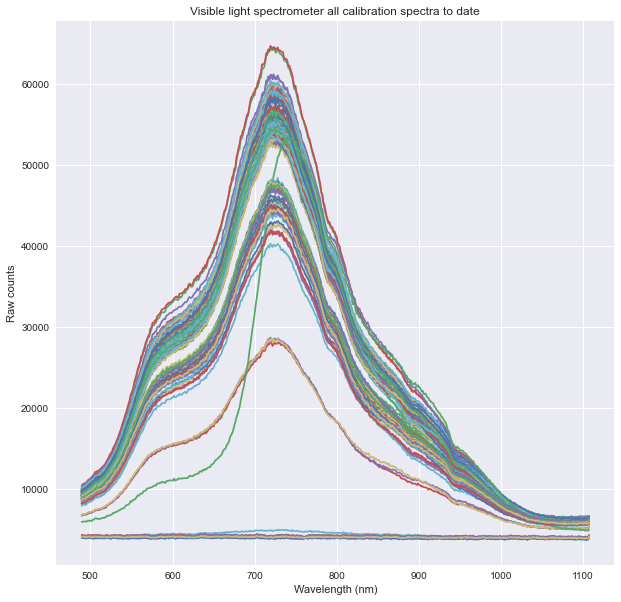

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible light spectrometer all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    try:
        vis_waves = get_visible_wavelength_vector(file, cal_path)
        vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        ax.plot(vis_waves, vis_cal_spectrum)
    except:
        print(file_name, cal_path)
plt.show()
plt.close()


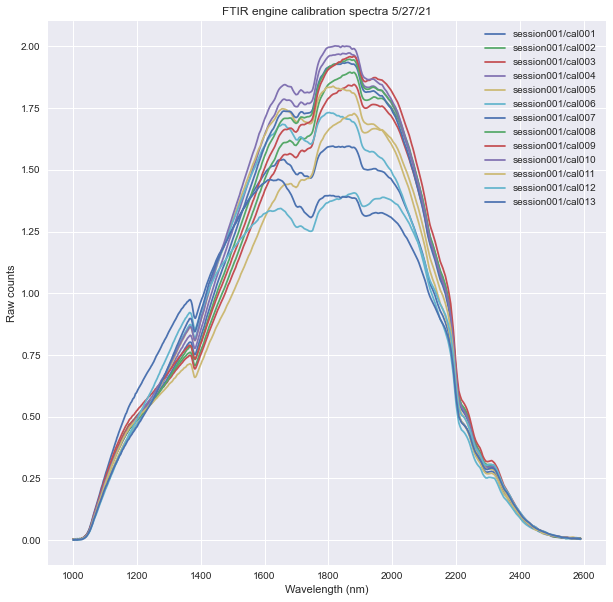

In [9]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/27/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR engine calibration spectra 5/27/21")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()


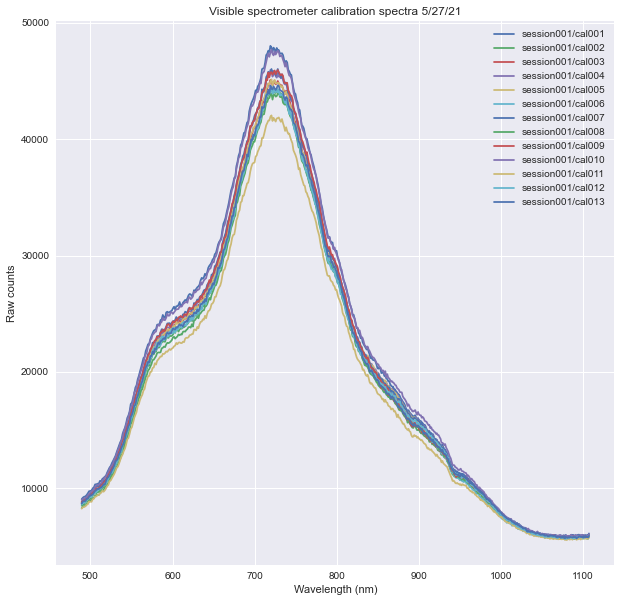

In [10]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/27/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible spectrometer calibration spectra 5/27/21")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        ax.plot(ftir_waves, ftir_cal_spectrum, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

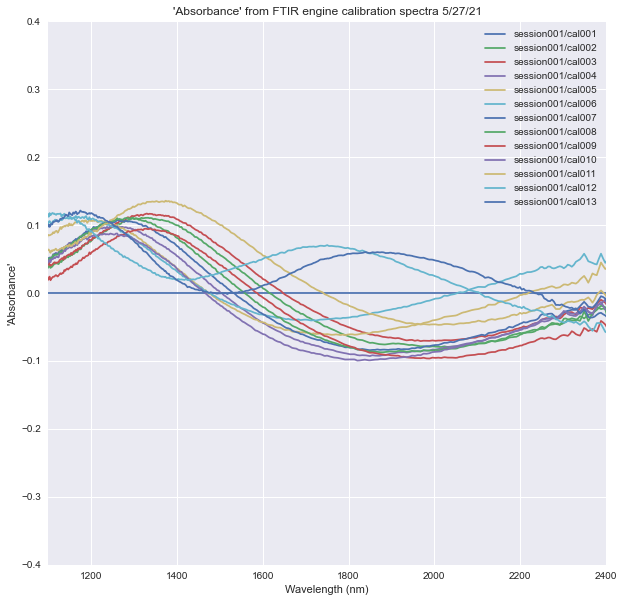

In [11]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/27/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session001/cal001'
reference_spectrum = get_ftir_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_ftir_dark_calibration_curve(file, reference_spectrum_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("'Absorbance' from FTIR engine calibration spectra 5/27/21")
ax.set_ylim(-0.4, 0.4)
ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_ftir_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, cal_absorbance, label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

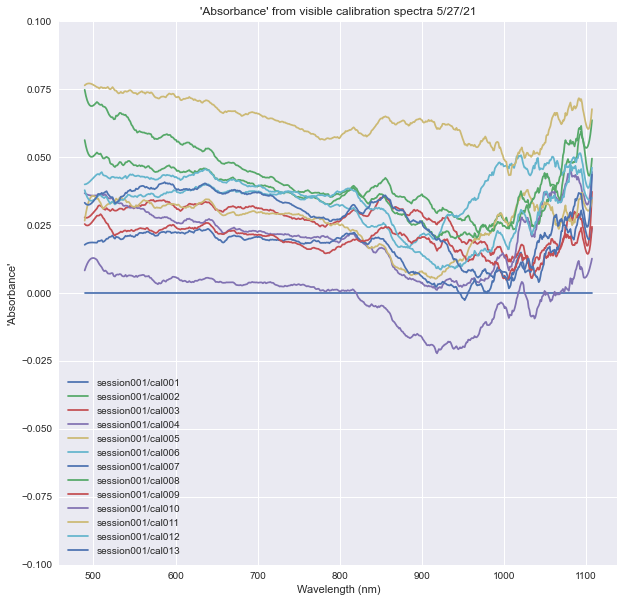

In [12]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
date = '5/27/21'
one_date_df = vis_cals_df.loc[vis_cals_df['date'] == date].copy()
file_name = one_date_df.iat[0, 0]
file = path_name + file_name
reference_spectrum_path = 'session001/cal001'
reference_spectrum = get_visible_white_calibration_curve(file, reference_spectrum_path)
dark_spectrum = get_visible_dark_calibration_curve(file, reference_spectrum_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("'Absorbance' from visible calibration spectra 5/27/21")
ax.set_ylim(-0.1, 0.1)
# ax.set_xlim(1100, 2400)
ax.set_ylabel("'Absorbance'")
ax.set_xlabel("Wavelength (nm)")
for index in one_date_df.index.values:
    file_name = one_date_df['file_name'][index]
    file = path_name + file_name
    cal_path = one_date_df['session'][index] + "/" + one_date_df['calibration'][index]
    try:
        ftir_waves = get_visible_wavelength_vector(file, cal_path)
        ftir_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
        cal_absorbance = calculate_absorbance_from_raw(ftir_cal_spectrum, reference_spectrum, dark_spectrum)
        ax.plot(ftir_waves, savgol_filter(cal_absorbance, 21, 3), label=cal_path)
    except:
        print(file, cal_path)
ax.legend()
plt.show()
plt.close()

Exception thrown for  5/24/21 session005/cal001


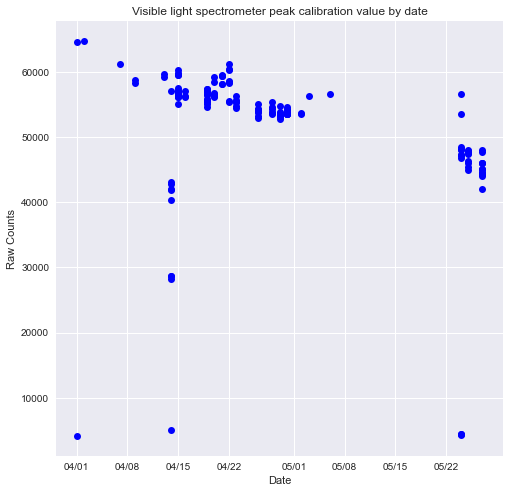

In [21]:
df = pd.read_csv('data/All_green_files210527.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
# print(vis_cals_df)

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
dates = []
date_strs = []
white_values = []
for i in range(vis_cals_df.shape[0]):
    entire_path = path_name + vis_cals_df.iat[i, 0]
    cal_path = vis_cals_df.iat[i, 2] + "/" + vis_cals_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    try:
        with h5py.File(entire_path, 'r') as h5_file: 
        
            spectrum = h5_file[cal_path].attrs['white_spectrum'][:]
            waves = h5_file[cal_path].attrs['spec1_wavelengths_vector'][:]
    except:
        print("Exception thrown for ", date_str, cal_path)
                
    white_value = spectrum.max()
    dates.append(date)
    date_strs.append(date_str)
    white_values.append(white_value)


fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Visible light spectrometer peak calibration value by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(10000, 20000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)


ax.plot_date(dates, white_values, 'bo')

plt.show()
plt.close()

Exception thrown for  5/24/21 session005/cal001


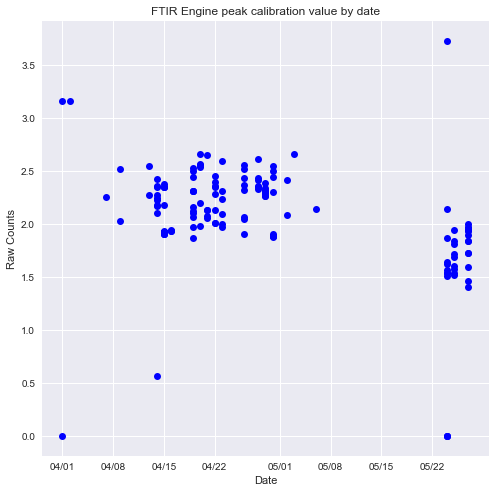

In [22]:
df = pd.read_csv('data/All_green_files210527.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
# print(vis_cals_df)

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
dates = []
date_strs = []
white_values = []
for i in range(vis_cals_df.shape[0]):
    entire_path = path_name + vis_cals_df.iat[i, 0]
    cal_path = vis_cals_df.iat[i, 2] + "/" + vis_cals_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    try:
        with h5py.File(entire_path, 'r') as h5_file: 
        
            spectrum = h5_file[cal_path].attrs['white_spectrum2'][:]
            waves = h5_file[cal_path].attrs['spec2_wavelengths_vector'][:]
    except:
        print("Exception thrown for ", date_str, cal_path)
                
    white_value = spectrum.max()
    dates.append(date)
    date_strs.append(date_str)
    white_values.append(white_value)


fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("FTIR Engine peak calibration value by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(10000, 20000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)


ax.plot_date(dates, white_values, 'bo')

plt.show()
plt.close()

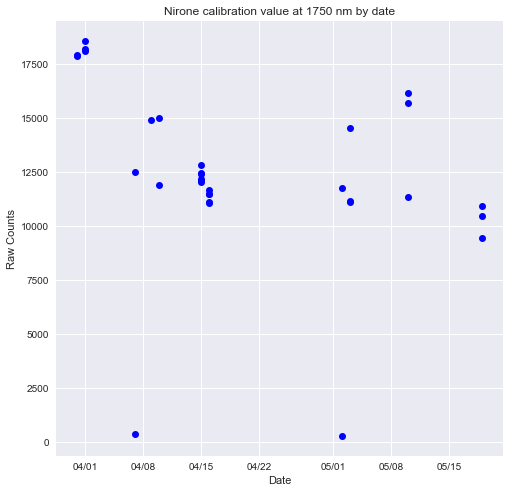

In [24]:
df = pd.read_csv('data/All_nirone_files_210527.csv')
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])
# print(vis_cals_df)

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
dates = []
date_strs = []
white_values = []
for i in range(vis_cals_df.shape[0]):
    entire_path = path_name + vis_cals_df.iat[i, 0]
    cal_path = vis_cals_df.iat[i, 2] + "/" + vis_cals_df.iat[i, 3]
    date_str = vis_cals_df.iat[i, 1]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    try:
        with h5py.File(entire_path, 'r') as h5_file: 
        
            spectrum = h5_file[cal_path].attrs['white_spectrum'][:]
            waves = h5_file[cal_path].attrs['spec1_wavelengths_vector'][:]
    except:
        print("Exception thrown for ", date_str, cal_path)
    
    index_value = np.where(waves == 1750.0)
    white_value = spectrum[index_value][0]
    dates.append(date)
    date_strs.append(date_str)
    white_values.append(white_value)


fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Nirone calibration value at 1750 nm by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(10000, 20000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)


ax.plot_date(dates, white_values, 'bo')

plt.show()
plt.close()